<a href="https://colab.research.google.com/github/eckoecho/Project-2/blob/main/World_Air_Quality_Index_by_City_and_Coordinates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# World Air Quality Analysis Notebook

## Introduction

Welcome to the World Air Quality Analysis notebook! This notebook explores insights derived from the World Air Quality Index (AQI) dataset obtained from [Kaggle](https://www.kaggle.com/datasets/adityaramachandran27/world-air-quality-index-by-city-and-coordinates). The primary objective is to gain a comprehensive understanding of air quality across different regions, enabling researchers and policymakers to make informed decisions in addressing the critical issue of air pollution.

### Dataset Overview

The dataset comprises 16,695 rows and 14 columns, with the target variable being the AQI Category. The AQI categories include Good, Moderate, Unhealthy for Sensitive Groups, Unhealthy, and Very Unhealthy. Each row represents a city or part of a city worldwide, making this dataset a valuable resource for evaluating the suitability of living conditions based on air quality.

### Analysis Goal

The main focus of this analysis is to develop a classification model for predicting the AQI Category of a given region. By doing so, we aim to provide insights into whether a country or city is a good choice to live based on its air quality status. The notebook will cover data exploration, cleaning, exploratory data analysis (EDA), feature engineering, model preparation, building, and evaluation.

### Challenges

Throughout the analysis, we anticipate challenges related to uncovering industry jargon present in the dataset and effectively plotting geographical areas. Overcoming these challenges is crucial for a comprehensive understanding of the dataset and accurate model development.

Feel free to explore the notebook to delve into the details of our analysis. Your contributions and insights are valuable as we work together to create a healthier environment for all.

# Imports

In [19]:
#importing necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

# Load Data

In [20]:
#Reading in CSV to dataframe
fpath="/content/drive/MyDrive/CodingDojo/02-MachineLearning/Week07/Data/AQI and Lat Long of Countries.csv"
df = pd.read_csv(fpath)
df.head()

,Country,City,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,PM2.5 AQI Value,PM2.5 AQI Category,lat,lng
0,Russian Federation,Praskoveya,51,Moderate,1,Good,36,Good,0,Good,51,Moderate,44.7444,44.2031
1,Brazil,Presidente Dutra,41,Good,1,Good,5,Good,1,Good,41,Good,-5.2900,-44.4900
2,Brazil,Presidente Dutra,41,Good,1,Good,5,Good,1,Good,41,Good,-11.2958,-41.9869
3,Italy,Priolo Gargallo,66,Moderate,1,Good,39,Good,2,Good,66,Moderate,37.1667,15.1833
4,Poland,Przasnysz,34,Good,1,Good,34,Good,0,Good,20,Good,53.0167,20.8833


In [21]:
#indicating rows and columms
df.shape
print(f"There are {df.shape[0]} rows, and {df.shape[1]} columns in our dataset.")

There are 16695 rows, and 14 columns in our dataset.


In [22]:
#A quick glance at our features, datatypes and any missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16695 entries, 0 to 16694
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country             16393 non-null  object 
 1   City                16695 non-null  object 
 2   AQI Value           16695 non-null  int64  
 3   AQI Category        16695 non-null  object 
 4   CO AQI Value        16695 non-null  int64  
 5   CO AQI Category     16695 non-null  object 
 6   Ozone AQI Value     16695 non-null  int64  
 7   Ozone AQI Category  16695 non-null  object 
 8   NO2 AQI Value       16695 non-null  int64  
 9   NO2 AQI Category    16695 non-null  object 
 10  PM2.5 AQI Value     16695 non-null  int64  
 11  PM2.5 AQI Category  16695 non-null  object 
 12  lat                 16695 non-null  float64
 13  lng                 16695 non-null  float64
dtypes: float64(2), int64(5), object(7)
memory usage: 1.8+ MB


In [23]:
#Viewing the spectrum of values
df.describe()

,AQI Value,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value,lat,lng
count,16695.000000,16695.000000,16695.000000,16695.000000,16695.000000,16695.000000,16695.000000
mean,62.998682,1.342138,31.767355,3.819647,59.821324,30.267148,-3.944485
std,43.091971,2.371379,22.839343,5.880677,43.208298,22.947398,73.037148
min,7.000000,0.000000,0.000000,0.000000,0.000000,-54.801900,-171.750000
25%,38.500000,1.000000,20.000000,0.000000,34.000000,16.515450,-75.180000
50%,52.000000,1.000000,29.000000,2.000000,52.000000,38.815800,5.643100
75%,69.000000,1.000000,38.000000,5.000000,69.000000,46.683300,36.275000
max,500.000000,133.000000,222.000000,91.000000,500.000000,70.767000,178.017800


> Note: An AQI value of 0.0000 for ozone may occur if the ozone concentration in the air is extremely low or falls below the detection limit of the monitoring equipment. It does not necessarily mean that ozone is completely absent, but rather that it is present at a very low concentration that falls below the threshold for reporting.

# Clean the Data

In [24]:
#Looking for duplicates to drop
df.duplicated().sum()

0

No duplicate values to drop.

In [25]:
#Looping thru the dataset's column values to find any labeling inconsistencies
#I'm including dropna=False to see any NaN values
for col in df:
    print(f"{df[col].value_counts(dropna=False)} \n\n")

United States of America    3954
Germany                     1072
Brazil                       890
Russian Federation           889
Italy                        866
                            ... 
Andorra                        1
Luxembourg                     1
Saint Lucia                    1
Guinea-Bissau                  1
Monaco                         1
Name: Country, Length: 175, dtype: int64 


Santa Cruz      17
San Fernando    16
Santa Ana       15
San Juan        14
Springfield     12
                ..
Hegang           1
Herxheim         1
Onalaska         1
Ostfildern       1
Westerville      1
Name: City, Length: 14229, dtype: int64 


50     413
52     374
35     366
51     359
54     352
      ... 
234      1
232      1
225      1
283      1
252      1
Name: AQI Value, Length: 282, dtype: int64 


Good                              7708
Moderate                          7054
Unhealthy                          871
Unhealthy for Sensitive Groups     869
Very Unhealthy    

In [26]:
#Checking for missing values
df.isna().sum()

Country               302
City                    0
AQI Value               0
AQI Category            0
CO AQI Value            0
CO AQI Category         0
Ozone AQI Value         0
Ozone AQI Category      0
NO2 AQI Value           0
NO2 AQI Category        0
PM2.5 AQI Value         0
PM2.5 AQI Category      0
lat                     0
lng                     0
dtype: int64

The `Country` feature has 302 missing values.  I'm going to look at the most common value for this column. However, I may be able to deduce the Country from the `lat` and `lng` features.

In [27]:
#Looking for the most common Country in our dataset
df["Country"].value_counts()

United States of America    3954
Germany                     1072
Brazil                       890
Russian Federation           889
Italy                        866
                            ... 
Luxembourg                     1
Saint Lucia                    1
Republic of Korea              1
Solomon Islands                1
Monaco                         1
Name: Country, Length: 174, dtype: int64

## Create Custom Function for seaborn plotting

I'm creating custom functions to re-use for my exploratory data section.

### Custom Barplot Function

In [28]:
#Creating custom barplot function
def value_barplot(x, y):
    #Plotting CO values
    fig, ax = plt.subplots()
    sns.barplot(df, x=x, y=y)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");
    ax.set_title(f"{x} vs. {y}", fontweight="bold");

### Custom Histogram Function

In [29]:
#Creating custom histogram function
def value_histo(x,y):
    #Setting size of plot
    fig, ax = plt.subplots(figsize=(12,5))
    #Plotting using in Histogram
    sns.histplot(df, y=y, x=x, hue=x)
    #Rotating and aligning x labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    #Setting title for plot
    ax.set_title(f"{x} vs. {y}", fontweight="bold");

### Custom Scatter Function

In [30]:
#Defining custom plot function
def scat(x,y):
    #Setting size of plot
    fig, ax = plt.subplots(figsize=(10,6))
    #Plotting using in scatterplot
    sns.scatterplot(df, x=x, y=y, hue=y)
    #Setting title for plot
    ax.set_title(f"{x} vs. {y}", fontweight="bold");

### Custom Contingency Table Function

In [31]:
#Creating custom contingency table for comparing category vs. category
def cont_table(x,y):
    # Create a contingency table
    contingency_table = pd.crosstab(df[x], df[y])
    # Plot a heatmap of the contingency table
    sns.heatmap(contingency_table)
    # Show the plot
    plt.show()

## Country

<ipython-input-32-93ca26b163a4>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


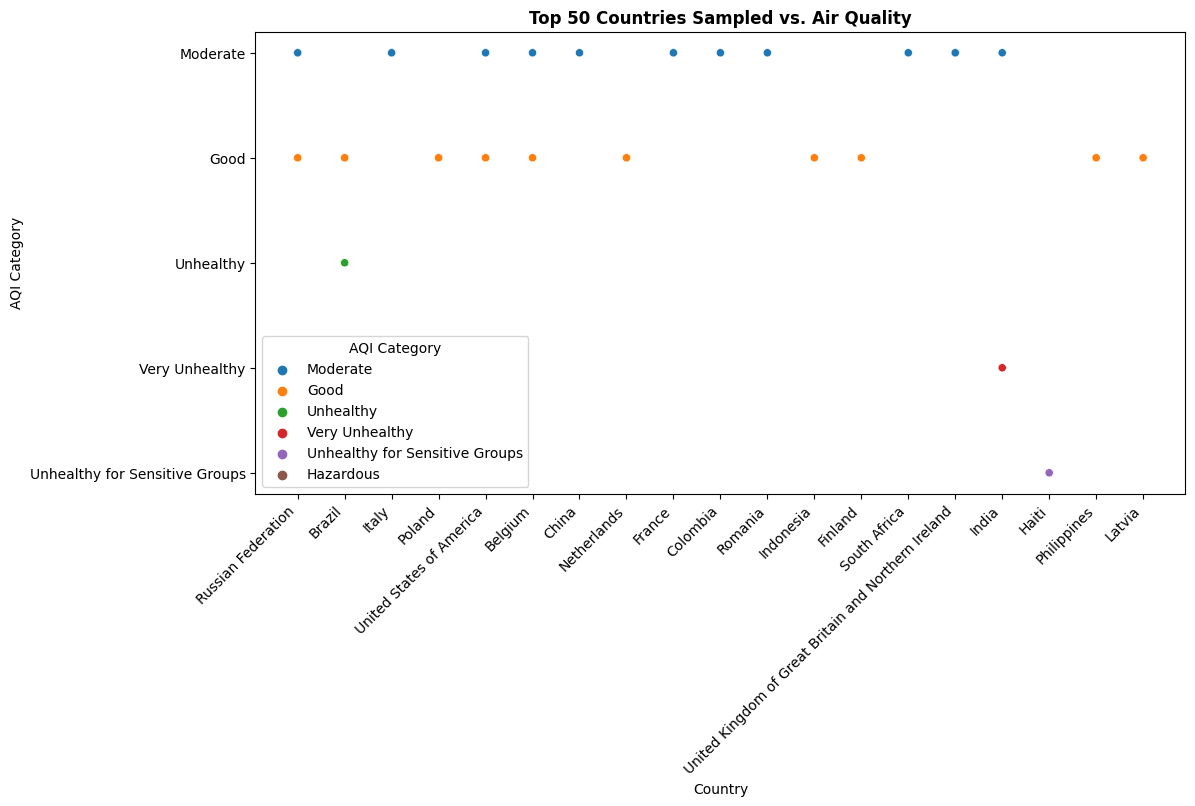

In [32]:
#Getting top 50 countries
top_countries = df["Country"].head(50)
#Setting plot size
fig, ax = plt.subplots(figsize=(12,6))
#Plotting x and y columns with hue highlighting
sns.scatterplot(df, y="AQI Category", x=top_countries, hue="AQI Category")
#Rotating x labels for readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
#Setting title for plot
ax.set_title("Top 50 Countries Sampled vs. Air Quality", fontweight="bold");

* **What type of feature is it? (Categorical (nominal), ordinal, numeric)**

     * Categorical - Nominal: meaning `Country` has no categorical order.

* **How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)**

    * 302 missing values. If it was more than 5% missing I would not drop the values. Since it's only 1.8% of this column's values, I will be dropping the missing values. 
    
* **Is the feature constant or quasi-constant?**

    * Quasi-constant because most Country's AQI Category is Good or Moderate.

* **What is the cardinality? Is it high (>10)?**

    * Yes, most countries are included which leads to a high cardinality.

* **Would we know this feature before the target is determined?**
    * Yes.

* **Is there a business case/understanding reason to exclude based on our business case?**

    * You could exclude the Country column since its very general.

## City

<ipython-input-33-0584e1f27858>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");


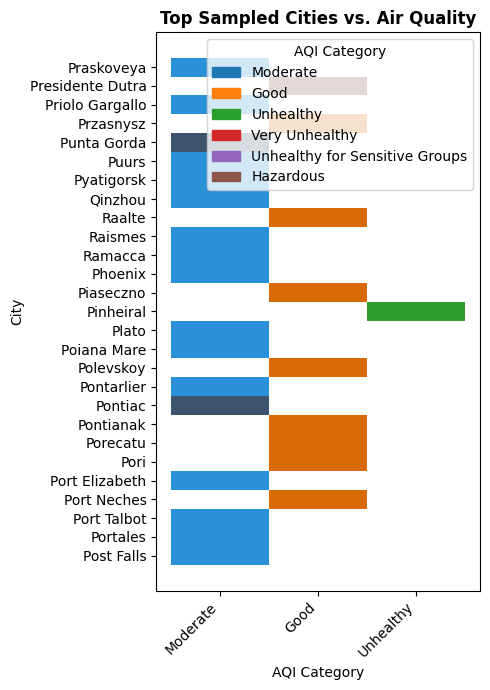

In [33]:
#Getting most occuring Cities to plot
top_cities = df["City"].head(30)
#Plotting Cities in Histoplot
fig, ax = plt.subplots(figsize=(5,7))
#Plotting x and y columns with hue highlighting
sns.histplot(df, x="AQI Category", y=top_cities, hue="AQI Category")
#Rotating x labels for readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
#Setting title for plot
ax.set_title("Top Sampled Cities vs. Air Quality", fontweight="bold")
fig.tight_layout();

* **What type of feature is it? (Categorical (nominal), ordinal, numeric)** 

    * Categorical - nominal
* **How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)**

    * All values present.
* **Is the feature constant or quasi-constant?**

    * Quasi-constant, most City's AQI Category is Good or Moderate.

* **What is the cardinality? Is it high (>10)?**

    * Yes, there is high cardinality since the dataset has many cities.
* **Would we know this feature before the target is determined?**

   *  Yes
* **Is there a business case/understanding reason to exclude based on our business case?**

    * Its possible to drop this column, since city to city the AQI levels can vary.

## AQI Value

<ipython-input-29-493c6b49fb13>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


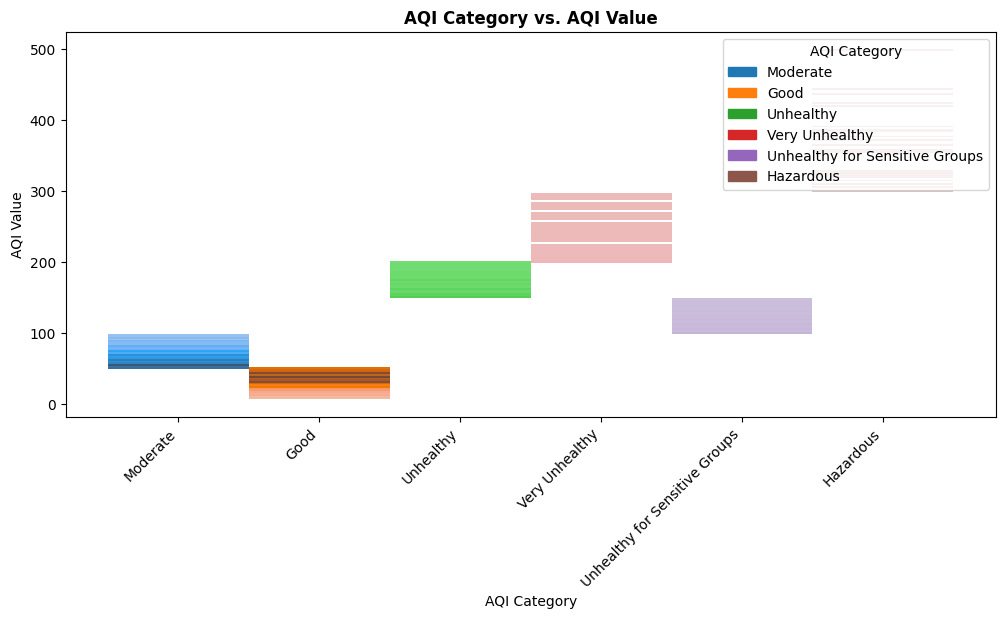

In [34]:
#Using custom function to plot
value_histo(y="AQI Value", x="AQI Category")

* **What type of feature is it? (Categorical (nominal), ordinal, numeric)**

    * Numeric

* **How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)**

    * All values present.
* **Is the feature constant or quasi-constant?**

    * Values are neither constant or quasi-constant, they are all varied
* **What is the cardinality? Is it high (>10)?**

    * This is a numeric column so cardinality is not relevant.
* **Would we know this feature before the target is determined?**

    * Yes
* **Is there a business case/understanding reason to exclude based on our business case?**

    * I would not exclude this info because it is multicollinearity to our target, AQI Category.

## CO AQI Value

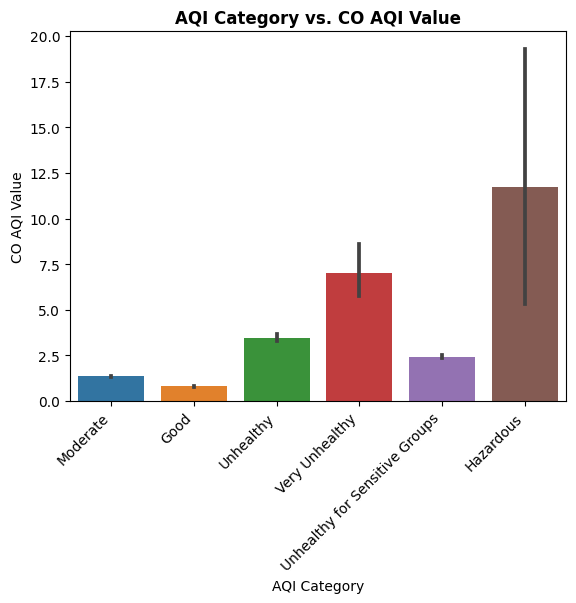

In [35]:
#Using custom function to plot
value_barplot("AQI Category","CO AQI Value")

* What type of feature is it? (Categorical (nominal), ordinal, numeric)

    Numerical

* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)

    All values are present.

* Is the feature constant or quasi-constant?

    Values are neither constant or quasi-constant, they are all varied.

* What is the cardinality? Is it high (>10)?

    This is a numeric column so cardinality is not relevant

* Would we know this feature before the target is determined?

    Yes

* Is there a business case/understanding reason to exclude based on our business case?

    Its possible that these values contribute to good or bad air quality so I suggest leaving this column in.

## CO AQI Category

<ipython-input-29-493c6b49fb13>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


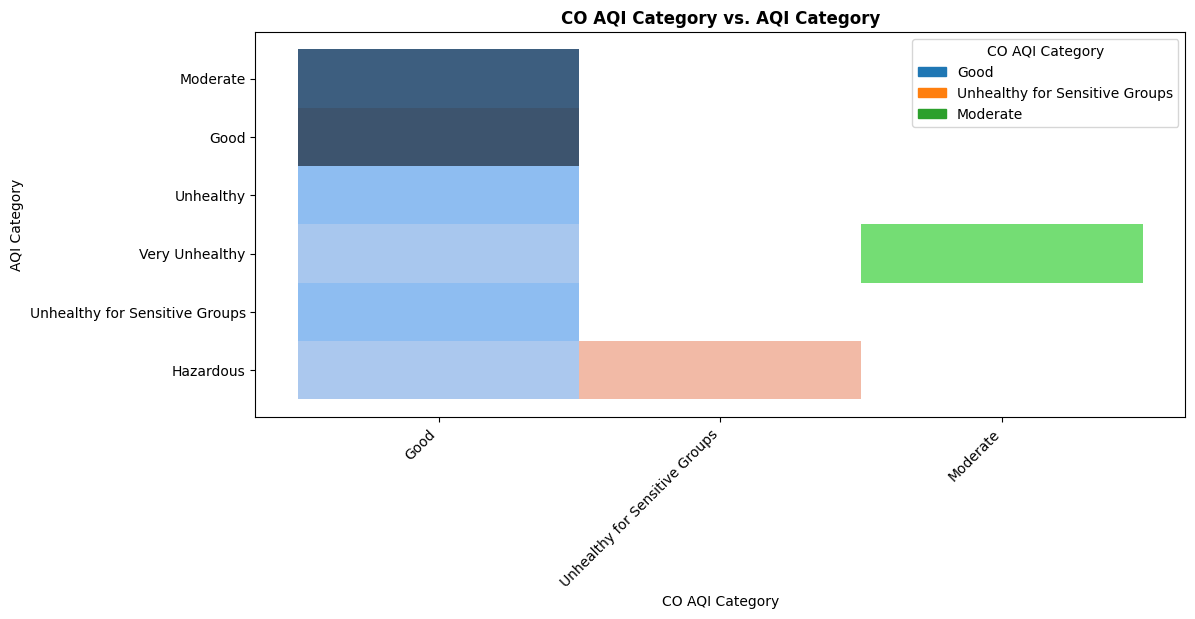

In [36]:
#Using custom function to plot
value_histo("CO AQI Category","AQI Category")

* What type of feature is it? (Categorical (nominal), ordinal, numeric)

    Categorical - ordinal

* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)

    All values present.

* Is the feature constant or quasi-constant?

    It is constant, with values belonging to good.

* What is the cardinality? Is it high (>10)?

    Does not have cardinality.

* Would we know this feature before the target is determined?

    Yes.

* Is there a business case/understanding reason to exclude based on our business case?

    I would not exclude this feature.

## Ozone AQI Value

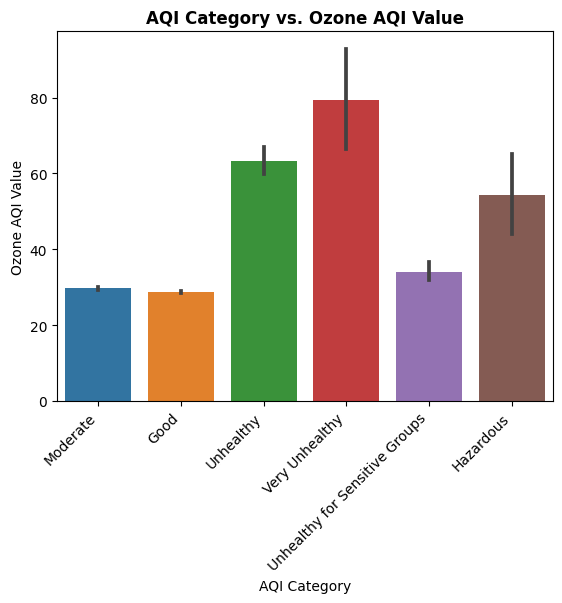

In [37]:
#Using custom function to plot
value_barplot("AQI Category","Ozone AQI Value")

* What type of feature is it? (Categorical (nominal), ordinal, numeric)

    Numeric

* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute?If impute, with what?)

    All values are present.

* Is the feature constant or quasi-constant?

    This feature is not constant or quasi-constant.

* What is the cardinality? Is it high (>10)?

    This is a numeric column so cardinality is not relevant

* Would we know this feature before the target is determined?

    Yes.

* Is there a business case/understanding reason to exclude based on our business case?

    I would include this in our dataset.

## Ozone AQI Category

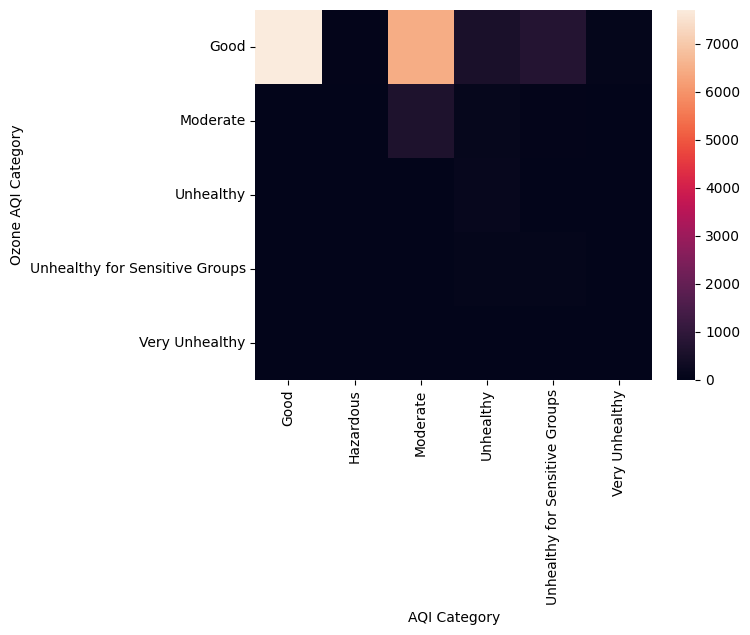

In [38]:
#Using custom function to plot
cont_table("Ozone AQI Category","AQI Category")

* What type of feature is it? (Categorical (nominal), ordinal, numeric)

    Categorical - ordinal

* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)

    All values present.

* Is the feature constant or quasi-constant?

    It is constant, with values belonging to good.

* What is the cardinality? Is it high (>10)?

    Does not have cardinality.

* Would we know this feature before the target is determined?

    Yes.

* Is there a business case/understanding reason to exclude based on our business case?

    I would not exclude this feature.

## NO2 AQI Value

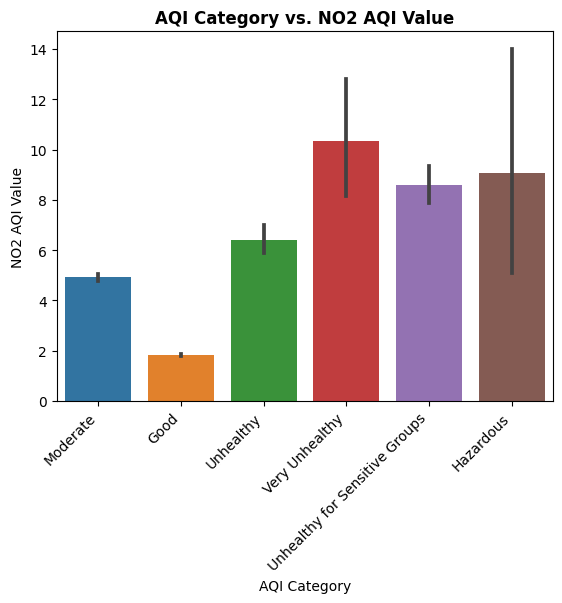

In [39]:
#Using custom function to plot
value_barplot("AQI Category", "NO2 AQI Value")

* What type of feature is it? (Categorical (nominal), ordinal, numeric)

    Numeric

* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute?If impute, with what?)

    All values are present.

* Is the feature constant or quasi-constant?

    This feature is not constant or quasi-constant.

* What is the cardinality? Is it high (>10)?

    This is a numeric column so cardinality is not relevant

* Would we know this feature before the target is determined?

    Yes.

* Is there a business case/understanding reason to exclude based on our business case?

    I would include this in our dataset.

## NO2 AQI Category

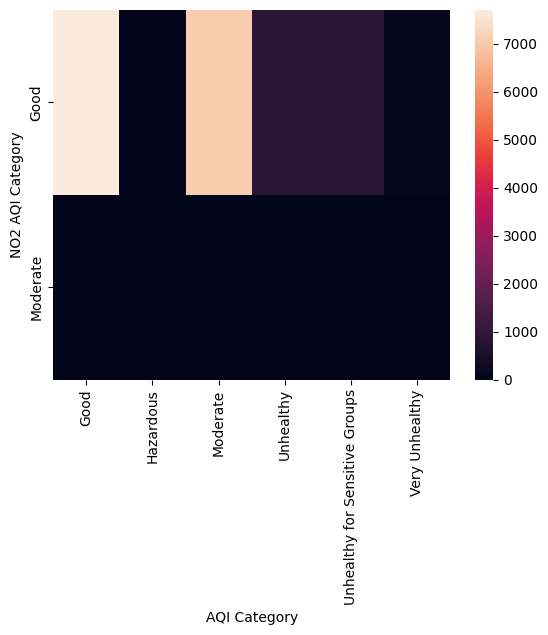

In [40]:
#Using custom function to plot
cont_table("NO2 AQI Category","AQI Category")

* What type of feature is it? (Categorical (nominal), ordinal, numeric)

    Categorical - ordinal

* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)

    All values present.

* Is the feature constant or quasi-constant?

    It is constant, with values belonging to good.

* What is the cardinality? Is it high (>10)?

    Does not have cardinality.

* Would we know this feature before the target is determined?

    Yes.

* Is there a business case/understanding reason to exclude based on our business case?

    I would not exclude this feature.

## PM2.5 AQI Value  

<ipython-input-29-493c6b49fb13>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


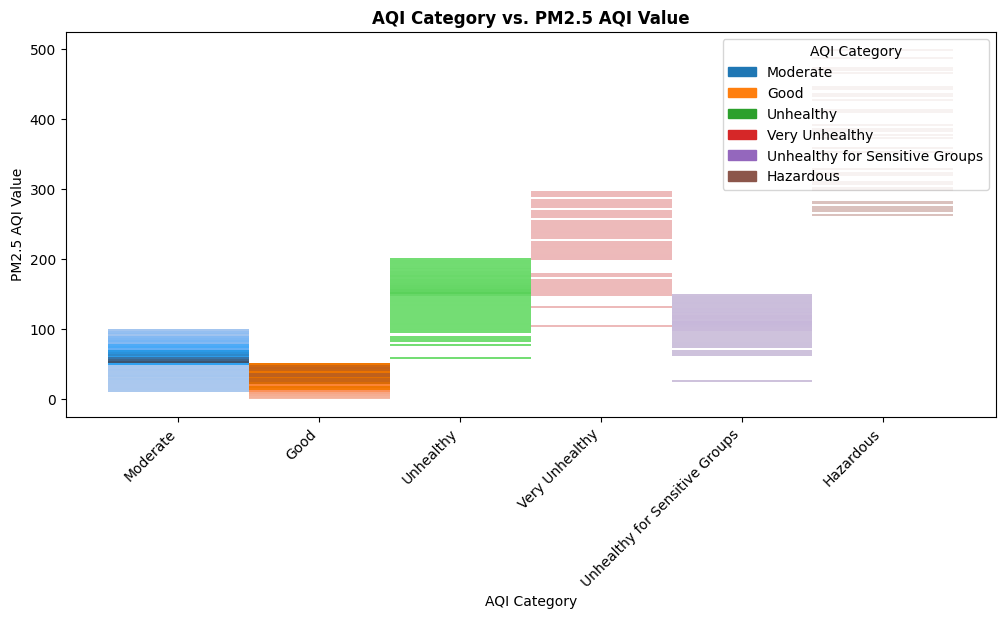

In [41]:
#Using custom function to plot
value_histo( "AQI Category","PM2.5 AQI Value")

* What type of feature is it? (Categorical (nominal), ordinal, numeric)

    Numeric

* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute?If impute, with what?)

    All values are present.

* Is the feature constant or quasi-constant?

    This feature is not constant or quasi-constant.

* What is the cardinality? Is it high (>10)?

    This is a numeric column so cardinality is not relevant

* Would we know this feature before the target is determined?

    Yes.

* Is there a business case/understanding reason to exclude based on our business case?

    I would include this in our dataset.

## PM2.5 AQI Category

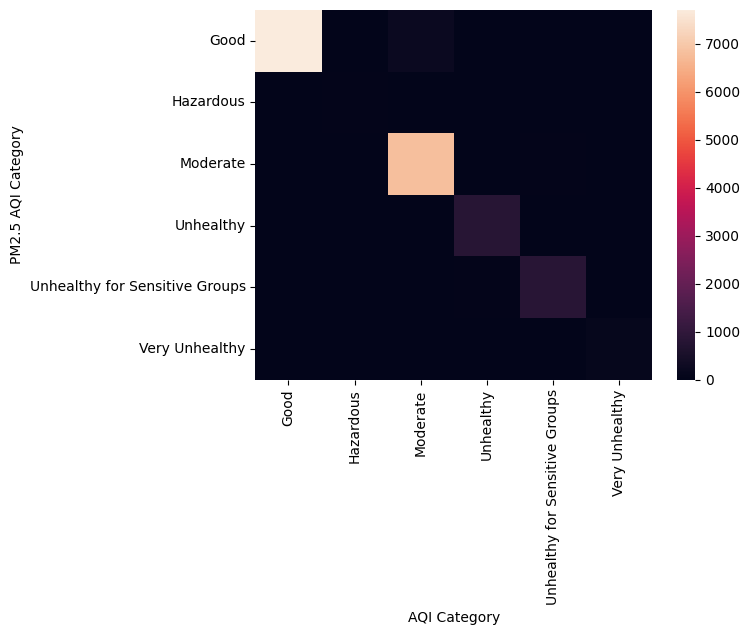

In [42]:
#Using custom function to plot
cont_table("PM2.5 AQI Category", "AQI Category")

* What type of feature is it? (Categorical (nominal), ordinal, numeric)

    Categorical - ordinal

* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)

    All values present.

* Is the feature constant or quasi-constant?

    It is constant, with values belonging to good.

* What is the cardinality? Is it high (>10)?

    Does not have cardinality.

* Would we know this feature before the target is determined?

    Yes.

* Is there a business case/understanding reason to exclude based on our business case?

    I would not exclude this feature.

## Correlation Heatmap

<ipython-input-43-4e94c5230a4c>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


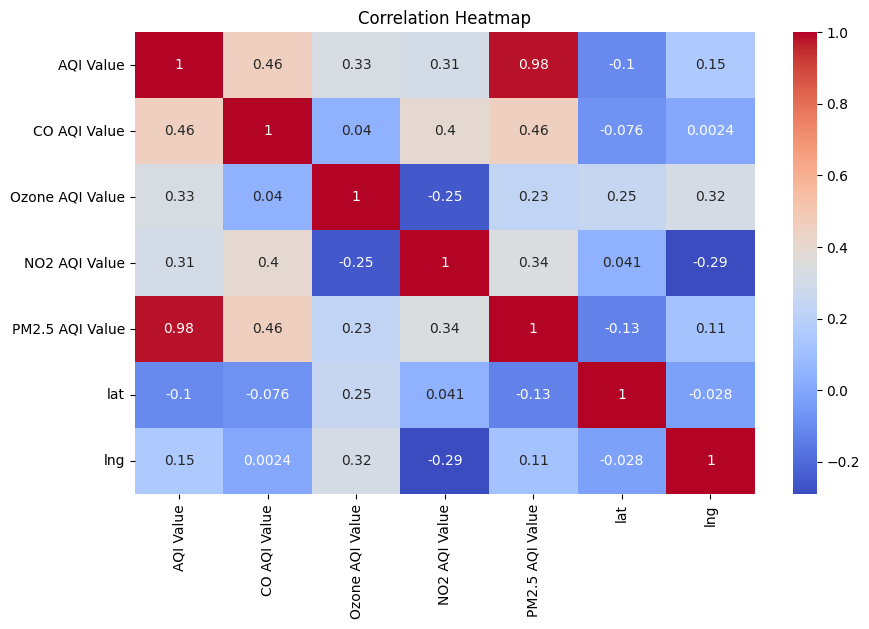

In [43]:
# Calculate the correlation matrix
corr_matrix = df.corr()
#Setting plot size
plt.figure(figsize=(10,6))
# Create a heatmap
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
#Setting title for plot
plt.title("Correlation Heatmap")
plt.show();

### Correlation Results

The highest numeric corrlations with our target `AQI Value` is `PM2.5 AQI Value` (correlation of .98) followed by `CO AQI Value` (corrleation of .46).

Correlation amongst features is between `CO AQI Value` and `PM2.5 AQI Value` (correlation of .46).

### AQI Category vs. PM2.5 AQI Value

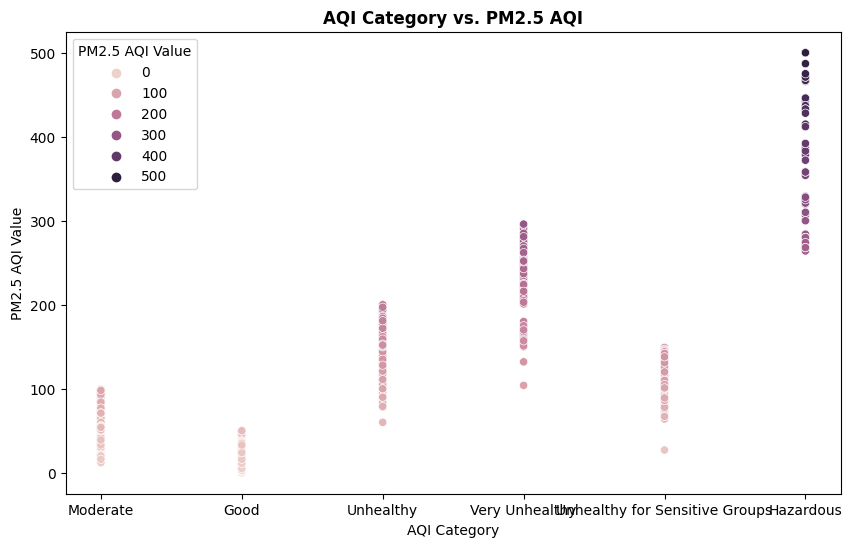

In [44]:
#Plotting AQI Value and PM2.5 Values
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(df, x="AQI Category", y="PM2.5 AQI Value", hue="PM2.5 AQI Value")
ax.set_title("AQI Category vs. PM2.5 AQI", fontweight="bold");

When comparing features, the most prominent influencer of air quality is the PM2.5 levels within a city. In the scatterplot, we can see higher levels of PM2.5 are only present when the air quality dips into the unhealthy air quality. Therefore, reducing or eliminating PM2.5 levels within a city improves the air quality. Smaller levels of PM2.5 ranging from 0 to 100 are toleratable to be considered in the good and moderate air qualities.

<ipython-input-45-3115d91cbc8c>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");


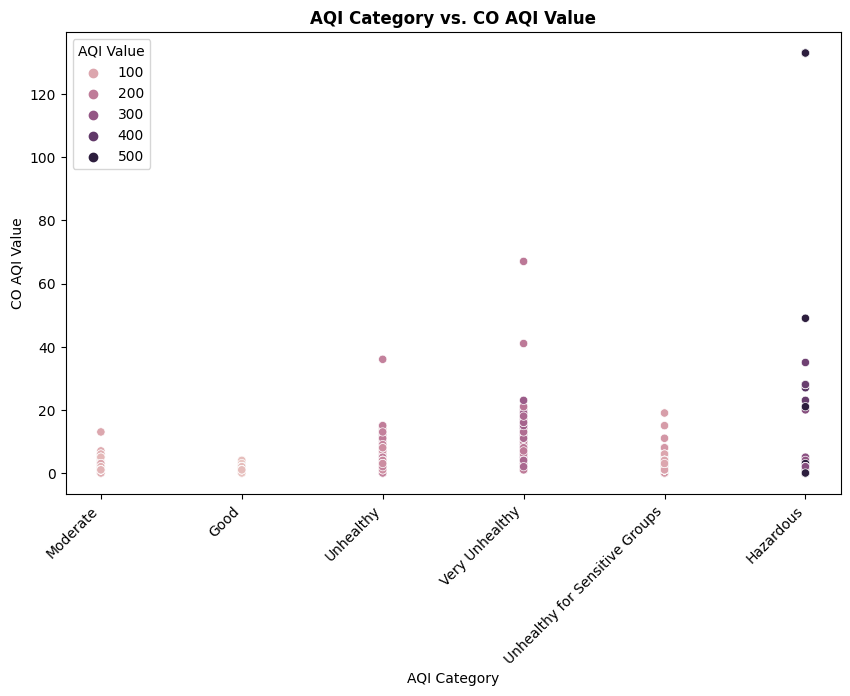

In [45]:
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(df, x="AQI Category", y="CO AQI Value", hue="AQI Value")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");
ax.set_title("AQI Category vs. CO AQI Value", fontweight="bold");

### CO AQI Value vs. PM2.5 AQI Value

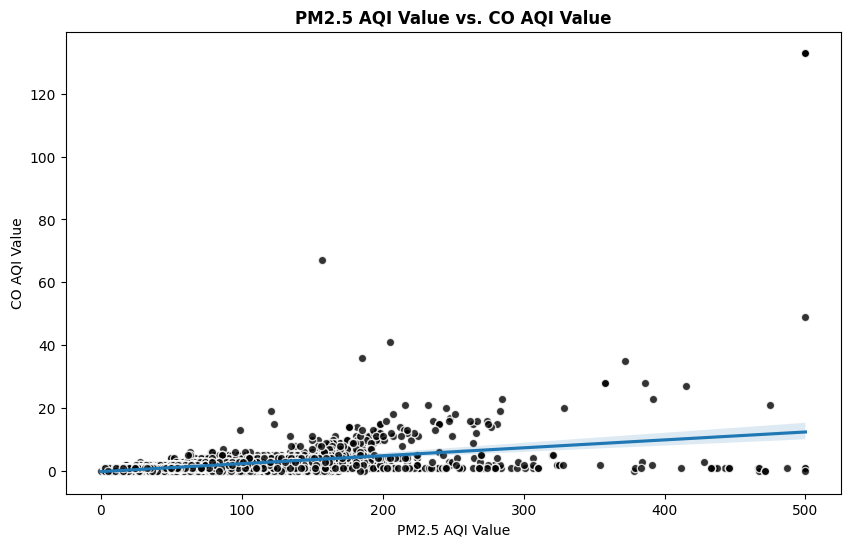

In [46]:
fig, ax = plt.subplots(figsize=(10,6))
sns.regplot(df, x="PM2.5 AQI Value", y="CO AQI Value", scatter_kws={"color": "black", "edgecolor":"white"})
ax.set_title("PM2.5 AQI Value vs. CO AQI Value", fontweight="bold");

This scatter plots shows the correlation between CO AQI values and PM2.5 values.  Though the correlation isn't drastic, the trendline is positively skewed leading us to see that higher levels of PM2.5 have some effect on CO AQI values.

### AQI Category vs. Ozone AQI Value

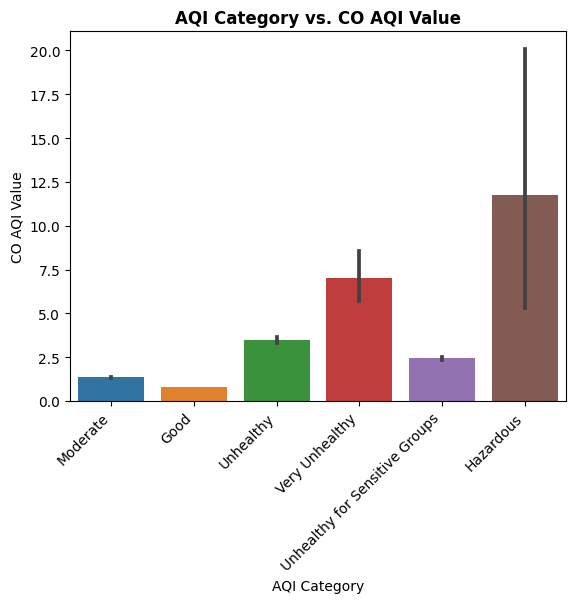

In [47]:
#Using custom function to plot
value_barplot("AQI Category","CO AQI Value")

# Exploratory Data Analysis

## AQI Category

Good                              7708
Moderate                          7054
Unhealthy                          871
Unhealthy for Sensitive Groups     869
Very Unhealthy                     131
Hazardous                           62
Name: AQI Category, dtype: int64


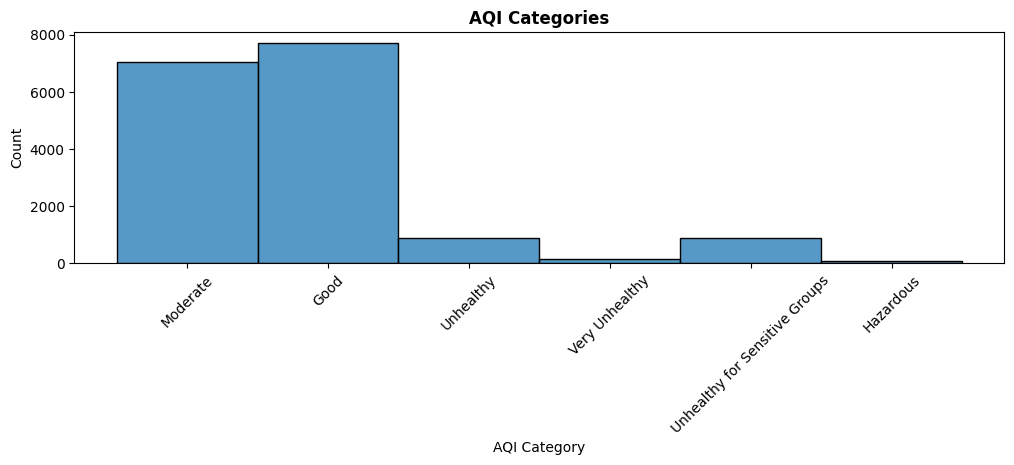

In [48]:
#Getting most occuring Categories to plot
aqi_category = df["AQI Category"]
print(aqi_category.value_counts())
#Plotting Categories in Countplot
fig, ax = plt.subplots(figsize=(12,3))
sns.histplot(df, x=aqi_category)
plt.xticks(rotation=45)
ax.set_title("AQI Categories", fontweight="bold");

* Collectively, 14,762 cities have moderate to good air quality. The majority of sampled countries/cities have an air quality score of moderate to good.

* Aggregating the unhealthy, very healthy, unhealthy for sensitive groups, and hazardous cateogries tells us there are 1,923 cities who's air qualities could be problematic.

* If we separate these values into percentages it means 11.51% of our sampled cities have unhealthy air qualities and 88.42% have healthy air qualities.



## AQI Category vs. PM2.5 AQI Value

<ipython-input-49-93895702f1e2>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


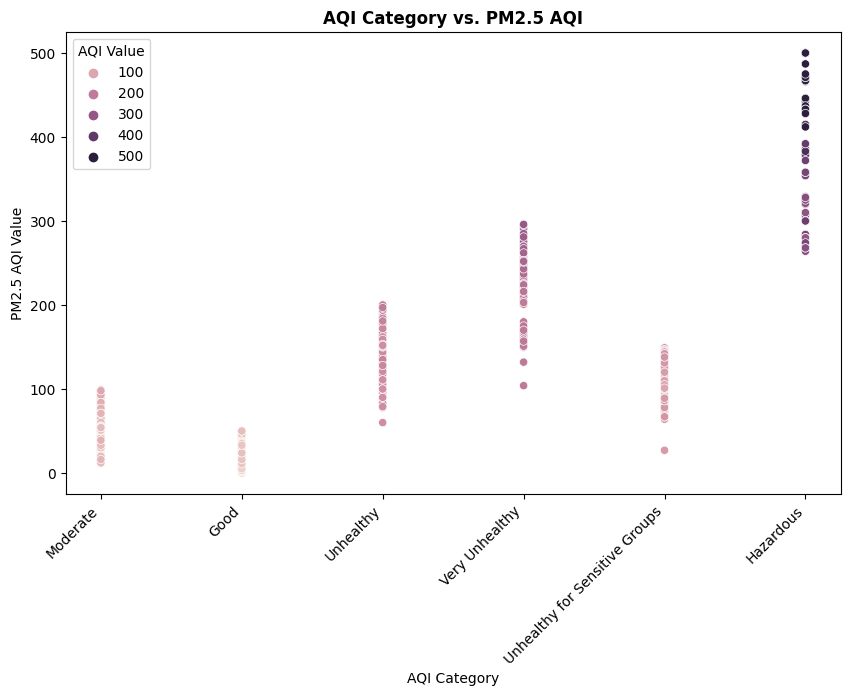

In [49]:
#Plotting AQI Value and PM2.5 Values
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(df, x="AQI Category", y="PM2.5 AQI Value", hue="AQI Value")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_title("AQI Category vs. PM2.5 AQI", fontweight="bold");

* The highest numeric corrlations with our target (AQI Value) is the PM2.5 AQI Value (correlation of .98).

* Higher values in PM2.5 means more pollutants. A lower number in `AQI Category` means a cleaner air quality.

* PM2.5 are tiny particles in the air that reduce visibility and cause the air to appear hazy when levels are elevated.

    >Health Effects include:
    * premature death in people with heart or lung disease.
    nonfatal heart attacks.
    * irregular heartbeat.
    * aggravated asthma.
    * decreased lung function.
    * increased respiratory symptoms, such as irritation of the airways, coughing or difficulty breathing.

* Our plot shows that higher PM2.5 values have a correlation to poorer/hazardous air qualitiy.

# Preprocessing

In [50]:
#Stating X and y
X = df.drop(columns="AQI Category")
y = df["AQI Category"]
X.head()

,Country,City,AQI Value,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,PM2.5 AQI Value,PM2.5 AQI Category,lat,lng
0,Russian Federation,Praskoveya,51,1,Good,36,Good,0,Good,51,Moderate,44.7444,44.2031
1,Brazil,Presidente Dutra,41,1,Good,5,Good,1,Good,41,Good,-5.2900,-44.4900
2,Brazil,Presidente Dutra,41,1,Good,5,Good,1,Good,41,Good,-11.2958,-41.9869
3,Italy,Priolo Gargallo,66,1,Good,39,Good,2,Good,66,Moderate,37.1667,15.1833
4,Poland,Przasnysz,34,1,Good,34,Good,0,Good,20,Good,53.0167,20.8833


## Binning

In [51]:
#Binning values in AQI Category for ease of readability
df["AQI Category"].replace({"Very Unhealthy": "Unhealthy",
                            "Unhealthy for Sensitive Groups": "Unhealthy", "Hazardous":"Unhealthy"}, inplace=True)
df["AQI Category"].value_counts()

Good         7708
Moderate     7054
Unhealthy    1933
Name: AQI Category, dtype: int64

## Train Test Split

In [52]:
#Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.head()

,Country,City,AQI Value,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,PM2.5 AQI Value,PM2.5 AQI Category,lat,lng
13525,United States of America,Park Ridge,64,2,Good,12,Good,20,Good,64,Moderate,41.0352,-74.0423
12752,Myanmar,Chauk,23,0,Good,23,Good,0,Good,18,Good,20.8833,94.8167
3527,Italy,Porcia,71,1,Good,29,Good,3,Good,71,Moderate,45.9667,12.6167
1791,Netherlands,Kampen,32,1,Good,29,Good,3,Good,32,Good,52.5500,5.9167
7333,Italy,Barletta,48,1,Good,48,Good,1,Good,35,Good,41.3167,16.2833


## Numerical

- Scale

In [53]:
#Dividing up column dtypes as to specifics for preprocessing
num_cols = make_column_selector(dtype_include="number")
df[num_cols]

,AQI Value,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value,lat,lng
0,51,1,36,0,51,44.7444,44.2031
1,41,1,5,1,41,-5.2900,-44.4900
2,41,1,5,1,41,-11.2958,-41.9869
3,66,1,39,2,66,37.1667,15.1833
4,34,1,34,0,20,53.0167,20.8833
...,...,...,...,...,...,...,...
16690,54,1,34,5,54,37.5516,-77.3285
16691,71,1,39,1,71,49.0650,18.9219
16692,71,1,39,1,71,36.3385,-88.8513
16693,50,1,20,5,50,48.7786,2.2906


In [54]:
#Instantiate Scaler
scaler = StandardScaler()
#Creating numeric pipeline
num_pipe = make_pipeline(scaler)
#Creating Tuple for ColumnTransformer
num_tuple = ("Numeric", num_pipe, num_cols)

## Ordinal

In [55]:
df["PM2.5 AQI Category"].value_counts()

Good                              7936
Moderate                          6882
Unhealthy for Sensitive Groups     881
Unhealthy                          828
Very Unhealthy                     115
Hazardous                           53
Name: PM2.5 AQI Category, dtype: int64

In [56]:
#Dividing up column dtypes as to specifics for preprocessing
ord_cols = ["CO AQI Category", "Ozone AQI Category", "NO2 AQI Category", "PM2.5 AQI Category"]
df[ord_cols]

,CO AQI Category,Ozone AQI Category,NO2 AQI Category,PM2.5 AQI Category
0,Good,Good,Good,Moderate
1,Good,Good,Good,Good
2,Good,Good,Good,Good
3,Good,Good,Good,Moderate
4,Good,Good,Good,Good
...,...,...,...,...
16690,Good,Good,Good,Moderate
16691,Good,Good,Good,Moderate
16692,Good,Good,Good,Moderate
16693,Good,Good,Good,Good


In [57]:
ord_cols = ["CO AQI Category", "Ozone AQI Category", "NO2 AQI Category", "PM2.5 AQI Category"]
#Putting columns in order for ordinal encoder
ordinal_order = [
    ["Unhealthy for Sensitive Groups", "Moderate", "Good"],  # CO AQI Category
    ["Good", "Moderate", "Unhealthy for Sensitive Groups", "Unhealthy", "Very Unhealthy"],  # Ozone AQI Category
    ["Good", "Moderate"],  # NO2 AQI Category
    ["Good", "Moderate", "Unhealthy for Sensitive Groups", "Unhealthy", "Very Unhealthy", "Hazardous"]  # PM2.5 AQI Category
]
#Instantiating scaler
scaler = StandardScaler()
#Instating encoder and putting in column order
ord = OrdinalEncoder(categories = ordinal_order)
#Creating pipe
ord_pipe = make_pipeline(ord,scaler)
#Create tuple for ColumnTransformer
ord_tuple = ("Ordinal", ord_pipe, ord_cols)

## Nominal

- Drop Missing Values
- OneHotEncoder

In [58]:
#Dividing up column dtypes as to specifics for preprocessing
ohe_cols = ["Country", "City"]
#Checking the perecentage of missing values
df[ohe_cols].isna().sum()/len(df["Country"]) * 100

Country    1.808925
City       0.000000
dtype: float64

In [59]:
# Find the rows with missing values in the 'Country' column
missing_countries = df['Country'].isnull()
# Print the rows with missing values for 'Country'
df[missing_countries]

,Country,City,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,PM2.5 AQI Value,PM2.5 AQI Category,lat,lng
385,NaN,Granville,30,Good,1,Good,30,Good,3,Good,25,Good,48.8381,-1.5869
560,NaN,Kingstown,163,Unhealthy,0,Good,25,Good,0,Good,163,Unhealthy,13.1578,-61.2250
623,NaN,Nanakuli,30,Good,0,Good,27,Good,0,Good,30,Good,21.3892,-158.1445
629,NaN,Lavagna,55,Moderate,1,Good,38,Good,2,Good,55,Moderate,44.3167,9.3333
664,NaN,Ladispoli,48,Good,1,Good,48,Good,2,Good,34,Good,41.9544,12.0742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16267,NaN,Tiverton,32,Good,1,Good,24,Good,7,Good,32,Good,41.6090,-71.1741
16279,NaN,Sorrento,61,Moderate,1,Good,45,Good,3,Good,61,Moderate,40.6278,14.3736
16456,NaN,Bima,25,Good,1,Good,25,Good,0,Good,24,Good,-8.4600,118.7267
16594,NaN,Marapanim,25,Good,1,Good,15,Good,0,Good,25,Good,-0.7139,-47.6939


Since the Country missing values only equal to 1.8%, I've decided to drop these values since they won't effect the outcome too much.

In [60]:
#Dropping missing values
df.dropna(subset=["Country"], inplace=True)
#Rechecking to ensure we dropped missing values
df["Country"].isna().sum()

0

In [61]:
#Instatiating OHE
ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
#Creating pipeline for transformation
ohe_pipe = make_pipeline(ohe)
#Create tuple for ColumnTransformer
ohe_tuple = ("Nominal", ohe_pipe, ohe_cols)

## ColumnTransformer

In [62]:
#Putting tuples in column transformer for parallet transformation
preprocessor = ColumnTransformer([num_tuple, ord_tuple, ohe_tuple],
                                 verbose_feature_names_out=False, remainder="drop")
preprocessor

ColumnTransformer(transformers=[('Numeric',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7a6ee69e4a90>),
                                ('Ordinal',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Unhealthy '
                                                                              'for '
                                                                              'Sensitive '
                                                                              'Groups',
                                                                              'Moderate',
                                                                              'Good'],
                                                                             ['Good',
                                                                              'Moderate',
                                                                              'Unhealthy '
                                                                              'for '
                                                                              'Sensiti...
                                                                              'Unhealthy '
                                                                              'for '
                                                                              'Sensitive '
                                                                              'Groups',
                                                                              'Unhealthy',
                                                                              'Very '
                                                                              'Unhealthy',
                                                                              'Hazardous']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['CO AQI Category', 'Ozone AQI Category',
                                  'NO2 AQI Category', 'PM2.5 AQI Category']),
                                ('Nominal',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Country', 'City'])],
                  verbose_feature_names_out=False)

In [63]:
# Fit the column transformer on the X_train
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('Numeric',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7a6ee69e4a90>),
                                ('Ordinal',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Unhealthy '
                                                                              'for '
                                                                              'Sensitive '
                                                                              'Groups',
                                                                              'Moderate',
                                                                              'Good'],
                                                                             ['Good',
                                                                              'Moderate',
                                                                              'Unhealthy '
                                                                              'for '
                                                                              'Sensiti...
                                                                              'Unhealthy '
                                                                              'for '
                                                                              'Sensitive '
                                                                              'Groups',
                                                                              'Unhealthy',
                                                                              'Very '
                                                                              'Unhealthy',
                                                                              'Hazardous']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['CO AQI Category', 'Ozone AQI Category',
                                  'NO2 AQI Category', 'PM2.5 AQI Category']),
                                ('Nominal',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Country', 'City'])],
                  verbose_feature_names_out=False)

### Transform Both Training and Testing Data

In [64]:
#Transform the Train and Test Data
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Modeling

## Decision Tree

Test Score:               precision    recall  f1-score   support

        Good       1.00      1.00      1.00      1952
    Moderate       1.00      1.00      1.00      1792
   Unhealthy       1.00      1.00      1.00       430

    accuracy                           1.00      4174
   macro avg       1.00      1.00      1.00      4174
weighted avg       1.00      1.00      1.00      4174



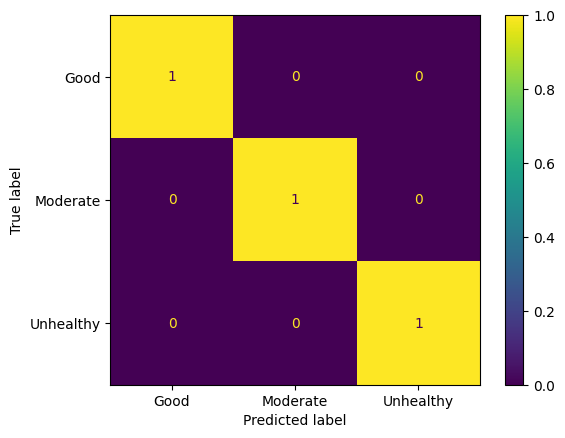

In [ ]:
#Instatiating Decision Tree
dec_tree = DecisionTreeClassifier(random_state=42)
#Create Decision Tree Pipe
dec_tree_pipe = make_pipeline(preprocessor, dec_tree)
#Fit training data
dec_tree_pipe.fit(X_train, y_train)
#Predict
train_preds = dec_tree_pipe.predict(X_train)
test_preds = dec_tree_pipe.predict(X_test)
#Getting metrics
print(f"Test Score: {classification_report(y_test,test_preds)}")
ConfusionMatrixDisplay.from_predictions(y_test, test_preds, normalize="true");

### Decision Tree w/ GridSearchCV

In [ ]:
#Instatiate Decision Tree
dec_tree = DecisionTreeClassifier(random_state=42)
#Create Decision Tree pipe
dec_tree_pipe = make_pipeline(preprocessor, dec_tree)
#State params for gridsearchcv
param_grid = {"decisiontreeclassifier__min_samples_split":[2,3,4],
              "decisiontreeclassifier__min_samples_leaf":[1,2,3],
              "decisiontreeclassifier__max_depth":[1,2,3]}
#Put pipe and params in GridSearchCV
dt_grid_search = GridSearchCV(dec_tree_pipe, param_grid)
#Fit on training
dt_grid_search.fit(X_train, y_train)
#Examine best params
dt_grid_search.best_params_

{'decisiontreeclassifier__max_depth': 2,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2}

### Tuned Decision Tree

Testing Score               precision    recall  f1-score   support

        Good       1.00      1.00      1.00      1952
    Moderate       1.00      1.00      1.00      1792
   Unhealthy       1.00      1.00      1.00       430

    accuracy                           1.00      4174
   macro avg       1.00      1.00      1.00      4174
weighted avg       1.00      1.00      1.00      4174



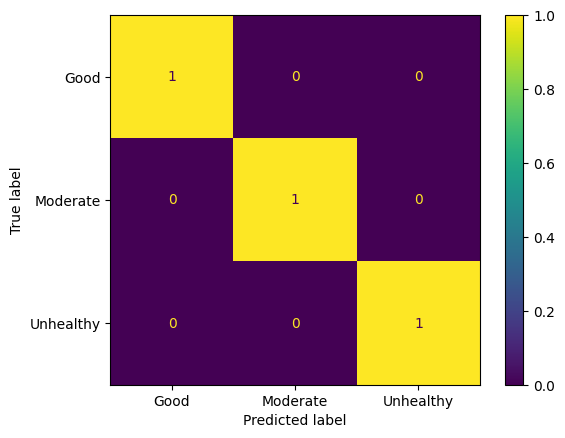

In [ ]:
#Instantiate Decision Tree
dec_tree = DecisionTreeClassifier(max_depth=2, min_samples_leaf=1,
                                  min_samples_split=2, random_state=42)
#Create Dec Tree pipe
dec_tree_pipe = make_pipeline(preprocessor, dec_tree)
#Fit on training data
dec_tree_pipe.fit(X_train, y_train)
#Predict
train_preds = dec_tree_pipe.predict(X_train)
test_preds = dec_tree_pipe.predict(X_test)
#Evaluate model performance
print(f"Testing Score {classification_report(y_test, test_preds)}")
ConfusionMatrixDisplay.from_predictions(y_test, test_preds, normalize="true");

## Random Forest

Test Scores               precision    recall  f1-score   support

        Good       1.00      1.00      1.00      1952
    Moderate       1.00      1.00      1.00      1792
   Unhealthy       1.00      1.00      1.00       430

    accuracy                           1.00      4174
   macro avg       1.00      1.00      1.00      4174
weighted avg       1.00      1.00      1.00      4174



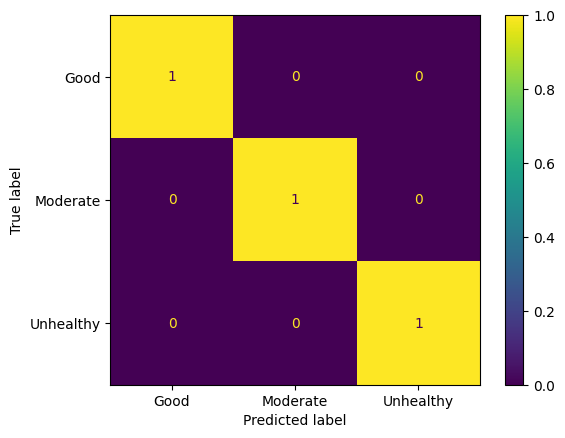

In [ ]:
#Instantiate Model
rf = RandomForestClassifier(random_state=42)
#Create pipe with model and ColumnTransformer
rf_pipe = make_pipeline(preprocessor, rf)
#Fit model on training data
rf_pipe.fit(X_train, y_train)
#Predictions
train_preds = rf_pipe.predict(X_train)
test_preds = rf_pipe.predict(X_test)
#Evaluate model
print(f"Test Scores {classification_report(y_test, test_preds)}")
ConfusionMatrixDisplay.from_predictions(y_test, test_preds, normalize="true")

### Random Forest w/ GridSearchCV

In [ ]:
#Instatiate Random Forest model
rf = RandomForestClassifier(random_state=42)
#Create Random Forest Pipe
rf_pipe = make_pipeline(preprocessor, rf)
param_grid={"randomforestclassifier__max_depth":range(1,10),
            "randomforestclassifier__min_samples_leaf":[2,3,4],
            "randomforestclassifier__min_samples_split":[2,3,4]}
#Instiate GridSearchCV
rf_grid_search = GridSearchCV(rf_pipe, param_grid)
#Fit on training
rf_grid_search.fit(X_train,y_train)
#Get the best params
rf_grid_search.best_params_

{'randomforestclassifier__max_depth': 9,
 'randomforestclassifier__min_samples_leaf': 2,
 'randomforestclassifier__min_samples_split': 2}

### Tuned Random Forest

Test Score:               precision    recall  f1-score   support

        Good       0.97      1.00      0.98      1952
    Moderate       0.80      0.96      0.88      1792
   Unhealthy       1.00      0.00      0.01       430

    accuracy                           0.88      4174
   macro avg       0.92      0.66      0.62      4174
weighted avg       0.90      0.88      0.84      4174



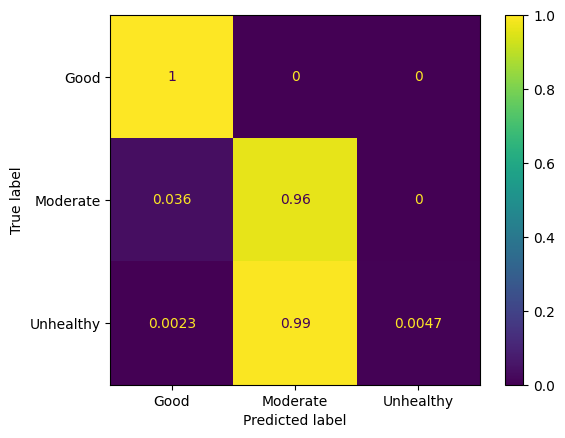

In [ ]:
#Instatiate Random Forest model
rf = RandomForestClassifier(max_depth=9, min_samples_leaf=2, min_samples_split=2)
#make pipeline w/ ColumnTransformer and random forest model
rf_pipe = make_pipeline(preprocessor, rf)
#Fitting our training data on model pipe
rf_pipe.fit(X_train,y_train)
#Predicting results
train_preds = rf_pipe.predict(X_train)
test_preds = rf_pipe.predict(X_test)
#Evaluating results
print(f"Test Score: {classification_report(y_test, test_preds)}")
#Displaying predictions in Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, test_preds, normalize="true");

## PCA w/ KNN

In [ ]:
#Creating pipe with scaler and PCA
pca_pipe = make_pipeline(preprocessor, PCA(.95))
#Instantiate KNN model
knn = KNeighborsClassifier()
#Create pipe with pca pip and model
knn_pipe = make_pipeline(pca_pipe,knn)
#Fit on training data
knn_pipe.fit(X_train, y_train)
train_preds = knn_pipe.predict(X_train)
test_preds = knn_pipe.predict(X_test)
print(f"Training Score: {classification_report(y_test, test_preds)}")
print(f"Testing Score: {classification_report(y_test, test_preds)}")

Training Score:               precision    recall  f1-score   support

        Good       1.00      1.00      1.00      1952
    Moderate       0.99      1.00      1.00      1792
   Unhealthy       1.00      0.99      1.00       430

    accuracy                           1.00      4174
   macro avg       1.00      0.99      1.00      4174
weighted avg       1.00      1.00      1.00      4174

Testing Score:               precision    recall  f1-score   support

        Good       1.00      1.00      1.00      1952
    Moderate       0.99      1.00      1.00      1792
   Unhealthy       1.00      0.99      1.00       430

    accuracy                           1.00      4174
   macro avg       1.00      0.99      1.00      4174
weighted avg       1.00      1.00      1.00      4174



## **PCA w/ Random Forest**

Training Score:               precision    recall  f1-score   support

        Good       1.00      1.00      1.00      1952
    Moderate       0.97      1.00      0.98      1792
   Unhealthy       1.00      0.87      0.93       430

    accuracy                           0.99      4174
   macro avg       0.99      0.95      0.97      4174
weighted avg       0.99      0.99      0.98      4174

Test Score:               precision    recall  f1-score   support

        Good       1.00      1.00      1.00      1952
    Moderate       0.97      1.00      0.98      1792
   Unhealthy       1.00      0.87      0.93       430

    accuracy                           0.99      4174
   macro avg       0.99      0.95      0.97      4174
weighted avg       0.99      0.99      0.98      4174



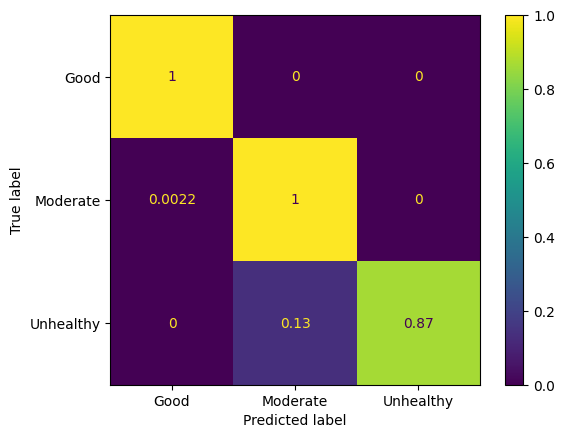

In [66]:
#Creating pipe with scaler and PCA
pca_pipe = make_pipeline(preprocessor, PCA(.95))
#Instantiate Random Forest
rf = RandomForestClassifier(random_state=42)
#Create another pipeline to run pca and model
rf_pipe = make_pipeline(pca_pipe, rf)
rf_pipe.fit(X_train,y_train)
train_preds = rf_pipe.predict(X_train)
test_preds = rf_pipe.predict(X_test)
print(f"Training Score: {classification_report(y_test, test_preds)}")
print(f"Test Score: {classification_report(y_test, test_preds)}")
#Displaying predictions in Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, test_preds, normalize="true");

# Recommendations

While other models, such as the Decision Tree and the tuned Decision Tree, may appear to have better F1 training and testing scores of 1, this actually indicates that the models are overfit and will not accurately predict new data.

My recommendation is to use the Random Forest model with PCA (Principal Component Analysis) because it achieves the best F1 scores. The F1 score considers both precision and recall. The Random Forest model with PCA achieves a testing F1 score of 1 for predicting good air quality, 0.98 for moderate air quality, and 0.93 for unhealthy air quality. The tuned Random Forest model also demonstrates good F1 scores on its testing data. However, when predicting "Unhealthy" air quality, its F1 score drops to 0.01. This is likely due to the limited number of "Unhealthy" data points compared to the number of good or moderate data points.

By incorporating PCA, the model is able to effectively reduce the dimensionality of the input data while retaining important features. This helps in capturing the underlying patterns and relationships within the data, leading to improved predictive performance.

Overall, the Random Forest model with PCA and my EDA findiings offers a robust and effective solution for accurately predicting air quality categories, making it a valuable tool for addressing questions on the air quality of a city and related decisions on the key indicators for policymakers.



